In [ ]:
!pip install librosa matplotlib numpy
!pip install scipy


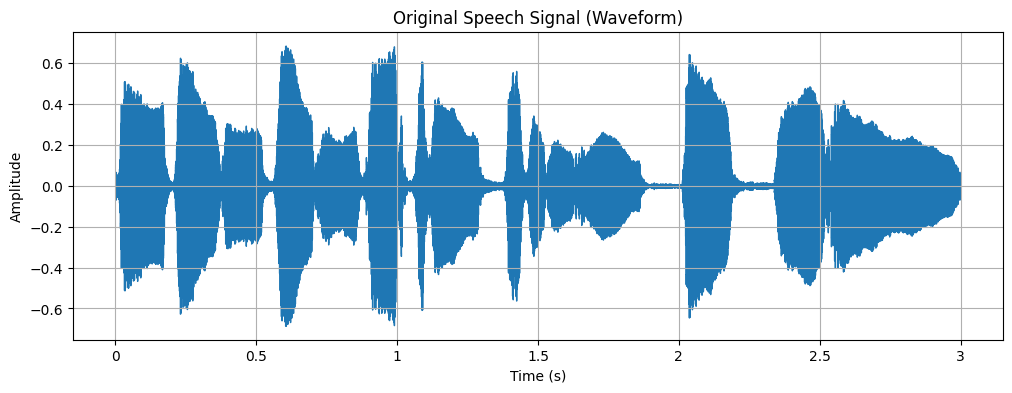

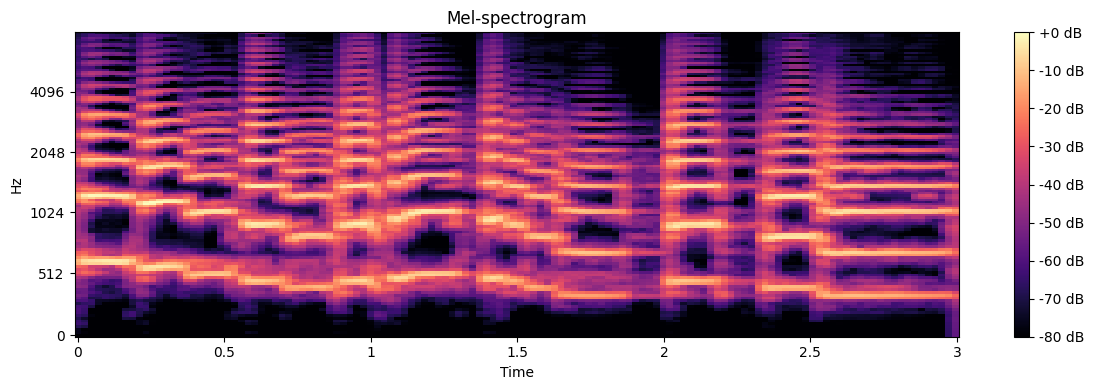

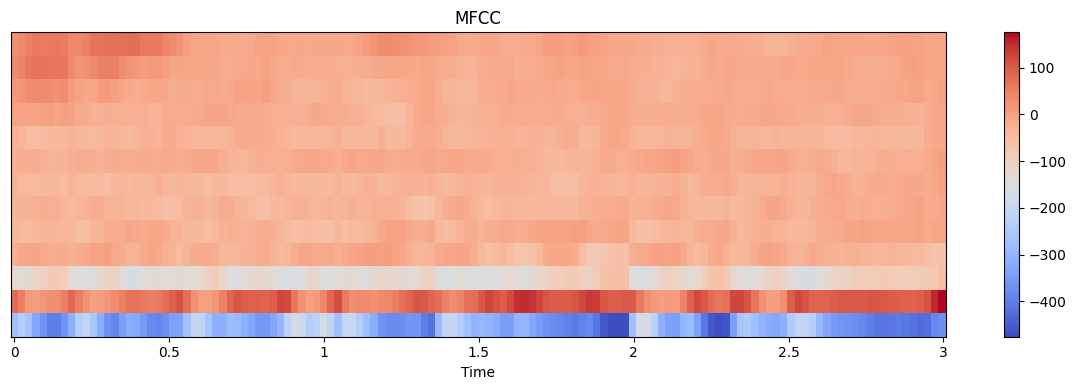

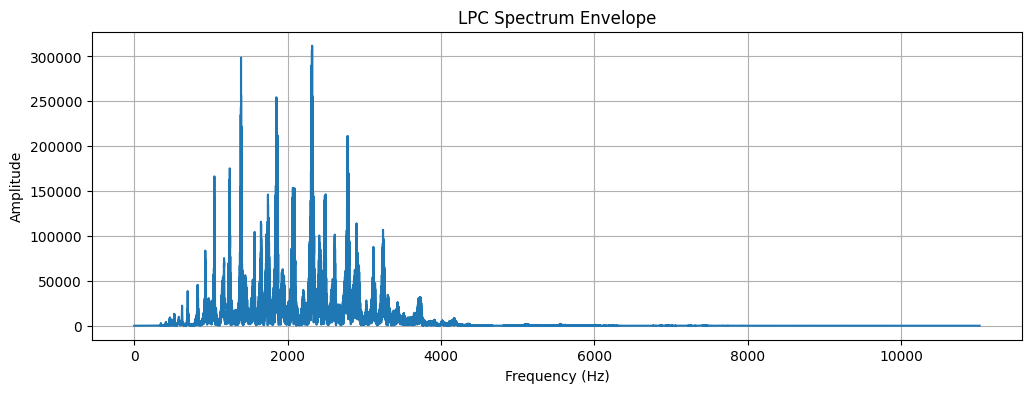

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display
from scipy.signal import lfilter

# Load a sample speech signal
y, sr = librosa.load(librosa.example('trumpet'), sr=None, duration=3)  # Speech-like sound

# Plot the original waveform
plt.figure(figsize=(12, 4))
librosa.display.waveshow(y, sr=sr)
plt.title('Original Speech Signal (Waveform)')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()

# Compute and plot the Mel-spectrogram
S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, fmax=8000)
S_dB = librosa.power_to_db(S, ref=np.max)
plt.figure(figsize=(12, 4))
librosa.display.specshow(S_dB, sr=sr, x_axis='time', y_axis='mel', fmax=8000)
plt.colorbar(format='%+2.0f dB')
plt.title('Mel-spectrogram')
plt.tight_layout()
plt.show()

# Compute and plot MFCCs
mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
plt.figure(figsize=(12, 4))
librosa.display.specshow(mfccs, x_axis='time')
plt.colorbar()
plt.title('MFCC')
plt.tight_layout()
plt.show()

# LPC implementation using autocorrelation
def lpc_auto_correlation(signal, order):
    # Compute autocorrelation
    autocorr = np.correlate(signal, signal, mode='full')
    autocorr = autocorr[len(autocorr)//2:]

    # Solve Levinson-Durbin recursion to get LPC coefficients
    lpc_coeffs = np.zeros(order + 1)
    lpc_coeffs[0] = 1
    error = autocorr[0]

    for i in range(1, order + 1):
        acc = sum(lpc_coeffs[j] * autocorr[i - j] for j in range(1, i))
        lpc_coeffs[i] = (autocorr[i] - acc) / error
        error *= (1 - lpc_coeffs[i] ** 2)

        for j in range(1, i // 2 + 1):
            temp = lpc_coeffs[j] + lpc_coeffs[i] * lpc_coeffs[i - j]
            lpc_coeffs[i - j] += lpc_coeffs[i] * lpc_coeffs[j]
            lpc_coeffs[j] = temp

    return lpc_coeffs

# Calculate LPC coefficients using autocorrelation
order = 16
lpc_coeffs = lpc_auto_correlation(y, order)

# Convert LPC coefficients to numpy array and negate
lpc_coeffs = np.array(lpc_coeffs)

# Apply LPC to obtain spectral envelope, ensuring negation works correctly
neg_lpc_coeffs = [0] + (-lpc_coeffs[1:]).tolist()  # Negate all but the first coefficient

# Apply LPC filtering
lpc_filtered_signal = lfilter(neg_lpc_coeffs, [1], y)

# Perform FFT on the LPC filtered signal
lpc_spectrum = np.fft.fft(lpc_filtered_signal, len(y))

# Plot LPC spectrum envelope
plt.figure(figsize=(12, 4))
plt.plot(np.linspace(0, sr / 2, len(lpc_spectrum) // 2), np.abs(lpc_spectrum[:len(lpc_spectrum) // 2]), label='LPC Envelope')
plt.title('LPC Spectrum Envelope')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()


In [ ]:
!pip install librosa matplotlib numpy

# Import required libraries
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display

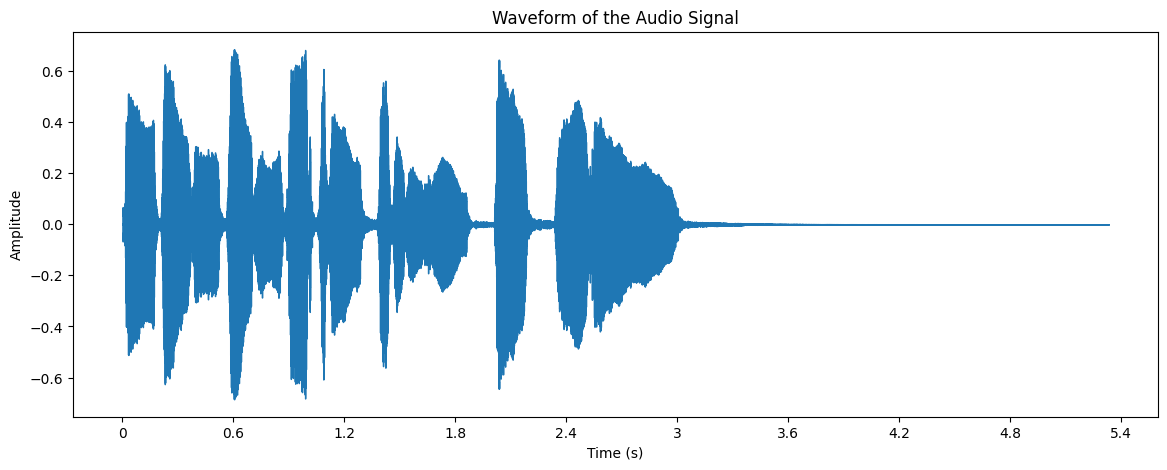

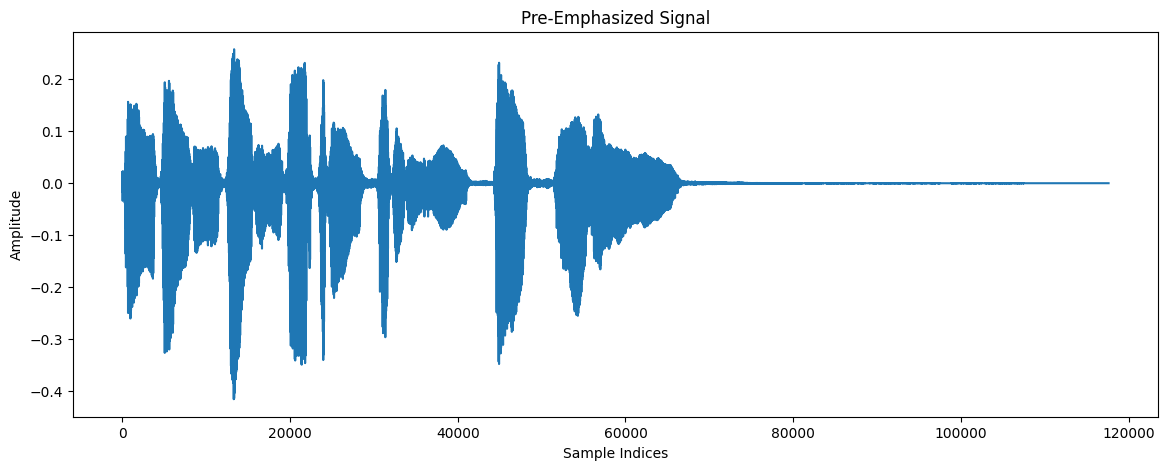

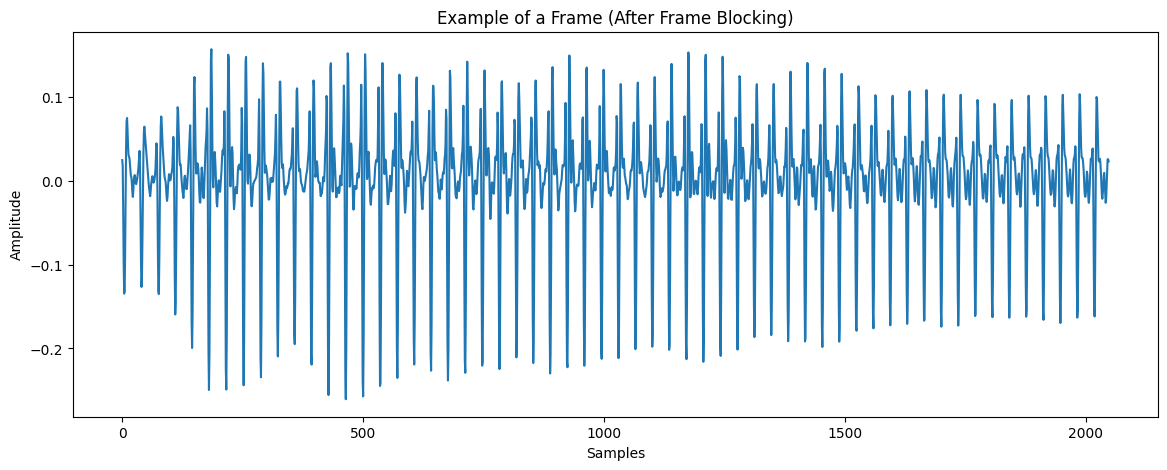

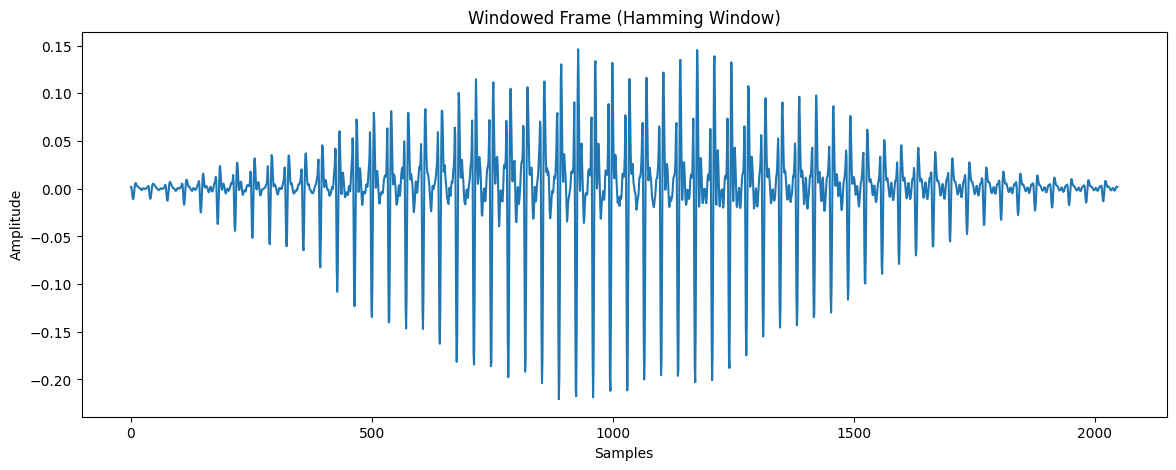

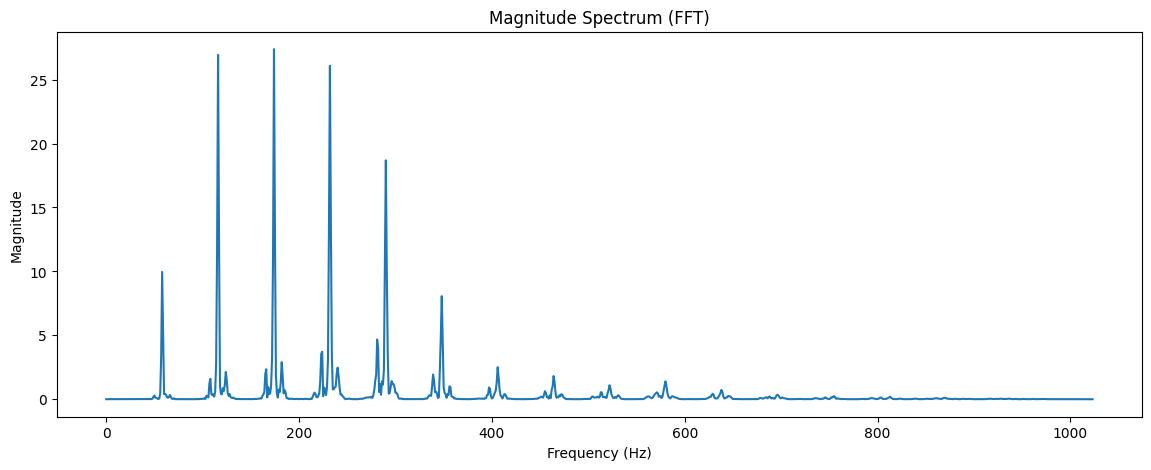

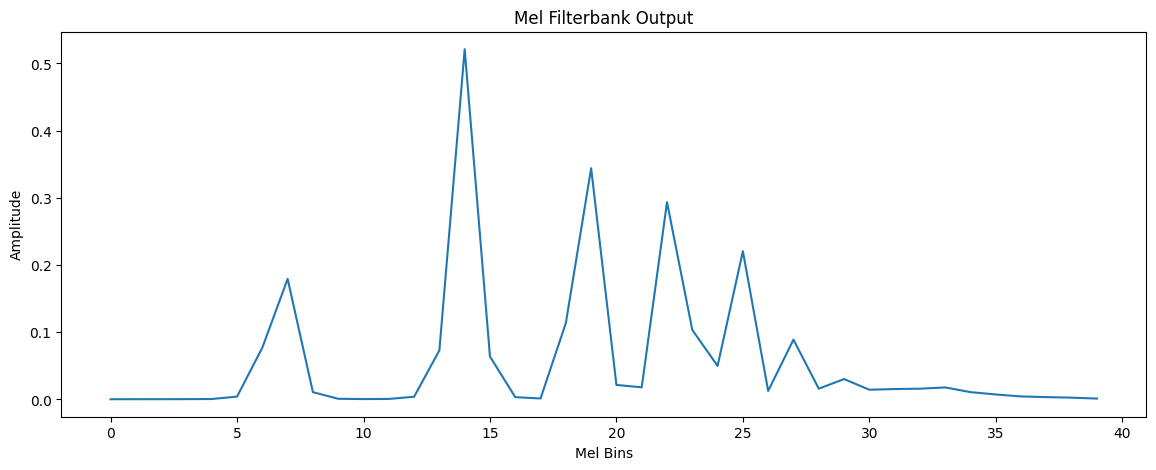

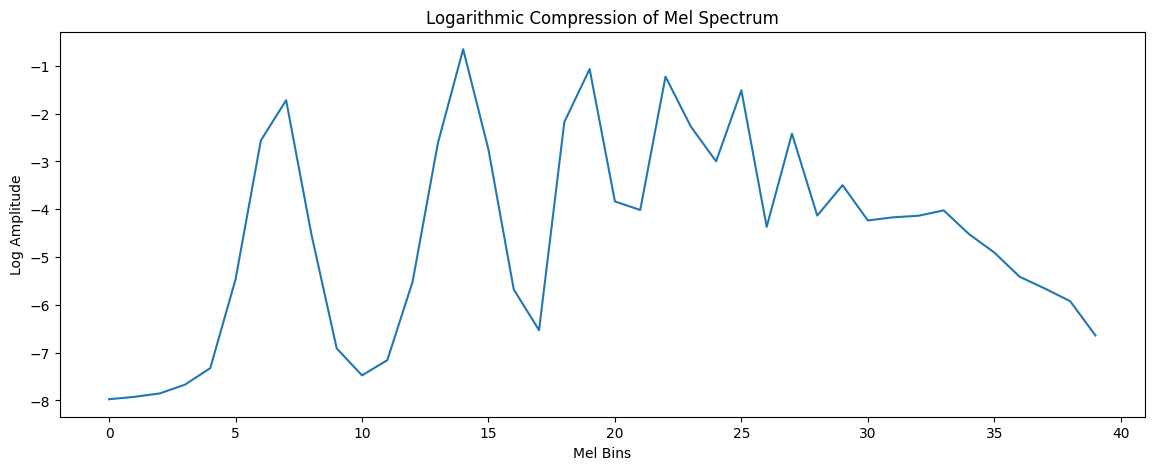

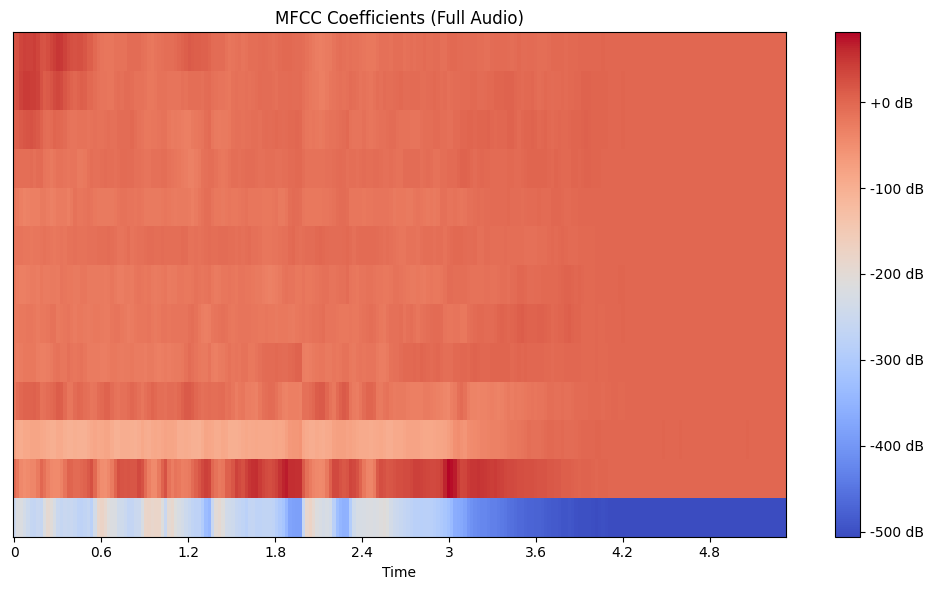

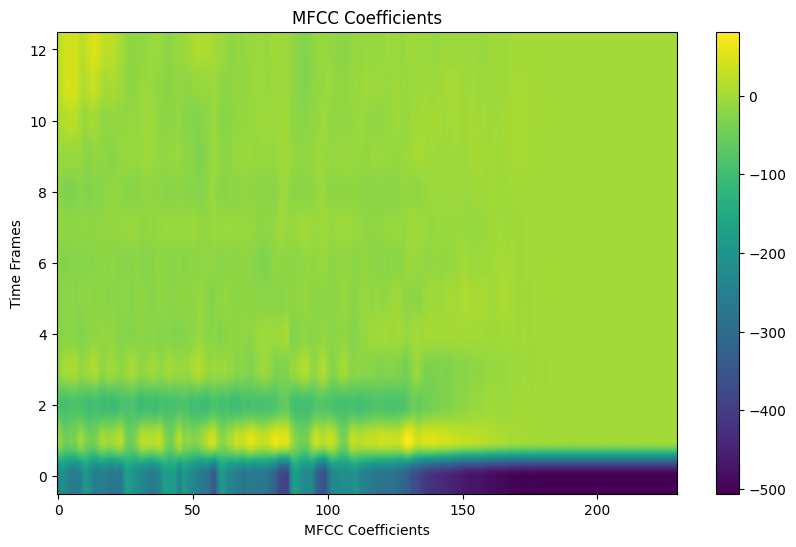

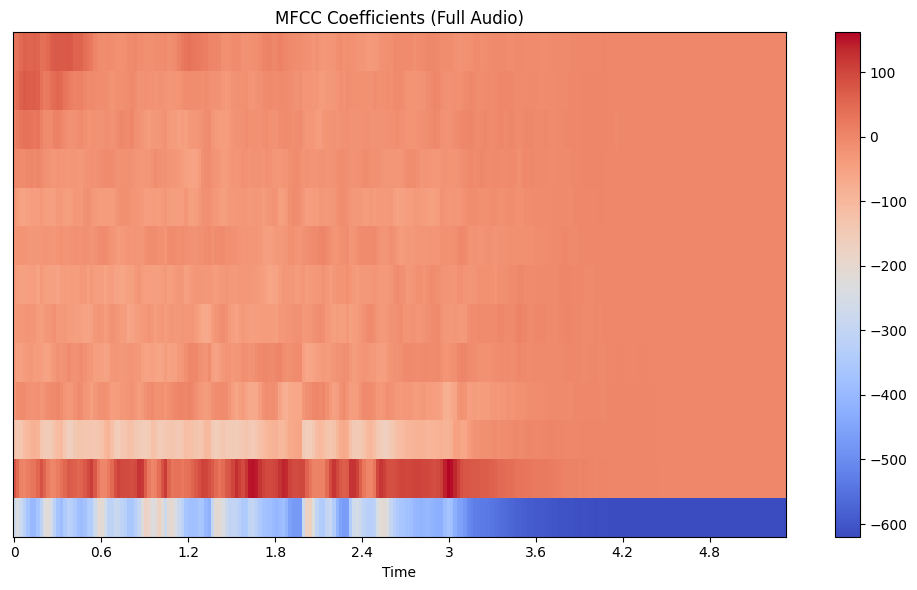

In [ ]:


# Load an example audio file (or upload your own)
audio_path = librosa.example('trumpet')  # You can replace this with your own audio file
y, sr = librosa.load(audio_path, sr=None)

# Visualize the waveform of the audio signal
plt.figure(figsize=(14, 5))
librosa.display.waveshow(y, sr=sr)
plt.title('Waveform of the Audio Signal')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()

# Step 1: Pre-Emphasis
pre_emphasis = 0.97
y_preemphasized = np.append(y[0], y[1:] - pre_emphasis * y[:-1])

# Visualize the pre-emphasized signal
plt.figure(figsize=(14, 5))
plt.plot(y_preemphasized)
plt.title('Pre-Emphasized Signal')
plt.xlabel('Sample Indices')
plt.ylabel('Amplitude')
plt.show()

# Step 2: Frame Blocking (using librosa to segment frames)
frame_length = 2048
hop_length = 512
frames = librosa.util.frame(y_preemphasized, frame_length=frame_length, hop_length=hop_length)

# Visualize the first few frames
plt.figure(figsize=(14, 5))
plt.plot(frames[:, 1])
plt.title('Example of a Frame (After Frame Blocking)')
plt.xlabel('Samples')
plt.ylabel('Amplitude')
plt.show()

# Step 3: Windowing (Hamming Window)
window = np.hamming(frame_length)
windowed_frame = frames[:, 1] * window

# Visualize the windowed frame
plt.figure(figsize=(14, 5))
plt.plot(windowed_frame)
plt.title('Windowed Frame (Hamming Window)')
plt.xlabel('Samples')
plt.ylabel('Amplitude')
plt.show()

# Step 4: Fast Fourier Transform (FFT)
fft = np.fft.fft(windowed_frame)
magnitude_spectrum = np.abs(fft)[:len(fft)//2]  # Take only the positive frequencies

# Visualize the FFT result
plt.figure(figsize=(14, 5))
plt.plot(magnitude_spectrum)
plt.title('Magnitude Spectrum (FFT)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.show()

# Step 5: Mel Filterbank
n_fft = frame_length  # Ensure n_fft is consistent with the frame length used for FFT
mel_filter_bank = librosa.filters.mel(sr=sr, n_fft=n_fft, n_mels=40)

# Correcting the magnitude_spectrum to include 1025 frequency bins
magnitude_spectrum = np.abs(fft)[:n_fft//2 + 1]  # Taking 1025 bins instead of 1024

# Apply the Mel filterbank
mel_spectrum = np.dot(mel_filter_bank, magnitude_spectrum)

# Visualize the Mel filterbank output
plt.figure(figsize=(14, 5))
plt.plot(mel_spectrum)
plt.title('Mel Filterbank Output')
plt.xlabel('Mel Bins')
plt.ylabel('Amplitude')
plt.show()


# Step 6: Logarithmic Compression
log_mel_spectrum = np.log(mel_spectrum + 1e-9)  # Add small value to avoid log(0)

# Visualize the log-compressed Mel spectrum
plt.figure(figsize=(14, 5))
plt.plot(log_mel_spectrum)
plt.title('Logarithmic Compression of Mel Spectrum')
plt.xlabel('Mel Bins')
plt.ylabel('Log Amplitude')
plt.show()

# Step 7: Discrete Cosine Transform (DCT) to get MFCCs
# You need to compute the log Mel-spectrogram for the entire signal
S = librosa.feature.melspectrogram(y=y_preemphasized, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=40)

# Apply logarithmic compression
log_S = librosa.power_to_db(S, ref=np.max)

# Compute the MFCCs from the log-mel spectrogram
mfccs = librosa.feature.mfcc(S=log_S, n_mfcc=13)

# Visualize the MFCCs
plt.figure(figsize=(10, 6))
librosa.display.specshow(mfccs, sr=sr, x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('MFCC Coefficients (Full Audio)')
plt.tight_layout()
plt.show()


# Visualize the MFCCs
plt.figure(figsize=(10, 6))
plt.imshow(mfccs, cmap='viridis', aspect='auto', origin='lower')
plt.title('MFCC Coefficients')
plt.xlabel('MFCC Coefficients')
plt.ylabel('Time Frames')
plt.colorbar()
plt.show()

# Extra Visualization: Full MFCC Extraction using librosa
mfccs_full = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13, hop_length=hop_length)

# Visualize the full MFCC matrix
plt.figure(figsize=(10, 6))
librosa.display.specshow(mfccs_full, sr=sr, x_axis='time')
plt.colorbar()
plt.title('MFCC Coefficients (Full Audio)')
plt.tight_layout()
plt.show()


In [ ]:
y_preemphasized

array([-1.4068222e-03,  9.1854506e-04,  2.1709624e-05, ...,
        2.1854274e-05, -3.8140439e-05,  4.2269559e-05], dtype=float32)